학습 목표: 
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련.

In [1]:
import os

# dataframe 작업용
import numpy as np
import pandas as pd

# sentence작업용
import re

# 데이터 분포 확인용
import matplotlib.pyplot as plt

# SubwordTextEncoder활용
import tensorflow_datasets as tfds

# 모델 학습시
from keras.callbacks import EarlyStopping 


import tensorflow as tf
print(tf.__version__)

2.6.0


### Step 1: 데이터 수집하기

In [2]:
os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/exploration/QUEST16'

In [3]:
df = pd.read_csv('./ChatbotData.csv', encoding='utf-8')
df.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


#### 데이터 dtype, 개수 확인

In [4]:
df.dtypes

Q        object
A        object
label     int64
dtype: object

In [5]:
df.Q.nunique() # 11662, 
df.A.nunique() # 7779
# Q와 A는 중복되는 값이 있다는 걸 알 수 있음.

df.label.nunique() # 3
df.isnull().sum() # 없음

Q        0
A        0
label    0
dtype: int64

In [46]:
df.groupby(['label']).count()
# 라벨의 의미가 긍정, 부정, 모호함
# 감성분석이외에는 의미가..?

,Q,A
label,,
0,2380,2380
1,2896,2896
2,2503,2503


### Step 2: 데이터 전처리하기

In [7]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (0-9, ㄱ-ㅎ, 가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^0-9ㄱ-ㅎ가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r'[0-9]+', "1", sentence)
    sentence = sentence.strip()
    return sentence

print("gogo")

gogo


In [8]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(df):
    inputs, outputs = [], []
#     df.drop_duplicates(subset = ['Q'], inplace=True) # 할때 안할때 결과가 달라짐.
    df.drop_duplicates(subset = ['A'], inplace=True)
    for i in range(len(df)):
#     for i in range(len(df)-1):
        inputs.append(preprocess_sentence(df['Q'].values[i]))
        outputs.append(preprocess_sentence(df['A'].values[i]))
                
    return inputs, outputs

print("gogo")

gogo


In [9]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(df)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전체 샘플 수 : 7779
전체 샘플 수 : 7779
전처리 후의 22번째 질문 샘플: 가족들이랑 서먹해
전처리 후의 22번째 답변 샘플: 다들 바빠서 이야기할 시간이 부족했나봐요 .


### Step 3: SubwordTextEncoder 사용하기

In [10]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호:' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호:' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print('VOCAB_SIZE:', VOCAB_SIZE)

# 예시_임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

START_TOKEN의 번호: [7779]
END_TOKEN의 번호: [7780]
VOCAB_SIZE: 7781
정수 인코딩 후의 21번째 질문 샘플: [3786, 1097, 147, 546, 30]
정수 인코딩 후의 21번째 답변 샘플: [1579, 6658, 5862, 7555, 71, 2780, 765, 1]


num_tokens길이: 15558
문장길이 최소: 1
문장길이 최대: 29
문장길이 평균: 5.946201311222522
문장길이 표준편차: 2.6071333426685572
MAX_LENGTH: 13
전체 문장의 0.9865663967090885%가 maxlen 설정값 이내에 포함됩니다. 


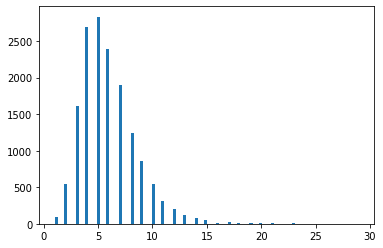

In [11]:
# 데이터셋 내 문장 길이 분포 확인
total_data_text = questions + answers
num_tokens = [len(tokenizer.encode(text)) for text in total_data_text] # 할때랑 결과가 달라짐
# num_tokens = [len(tokens) for tokens in total_data_text] # 34
num_tokens = np.array(num_tokens)
print("num_tokens길이:", len(num_tokens))  

# 문장길이의 최소값, 최대값, 평균값, 표준편차, 요약이 아니라서 단어 수의 분포를 볼 필요는 없지만 대략적인 파악을 위해 실행했음.
print('문장길이 최소:', np.min(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))

# 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3*np.std(num_tokens)
MAX_LENGTH = int(max_tokens)  # 10쯤으로 잡을때 accuray가 높아짐, 13미만
print("MAX_LENGTH:", MAX_LENGTH)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

plt.hist(num_tokens, bins=100)
plt.show()

In [12]:
MAX_LENGTH = 10

In [13]:
# num_tokens = [len(tokens) for tokens in total_data_text]
# print("num_tokens:", num_tokens)

# num_tokens2 = [len(tokenizer.encode(text)) for text in total_data_text]
# print("num_tokens2:", num_tokens2)

In [14]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
# 최대 길이를 초과하는 부분은 사실 위에서 했지만, 한번더!
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs
print("gogo")

gogo


In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 7781
필터링 후의 질문 샘플 개수: 5754
필터링 후의 답변 샘플 개수: 5754


In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("gogo")

gogo


### Step 4: 모델 구성하기

#### Transformer 모델
1. PositionalEncoding
2. MultiHeadAttention (Scaled_dot_product_attention) 

In [17]:
# 1. PositionalEncoding
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("gogo")

gogo


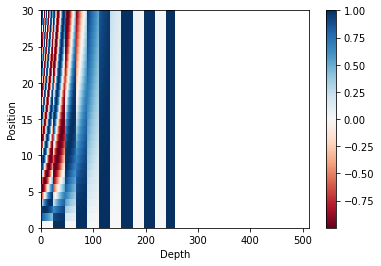

In [18]:
# sample_pos_encoding = PositionalEncoding(50, 128)
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [19]:
# 2. MultiHeadAttention (Scaled_dot_product_attention) 
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

#### 마스킹

In [21]:
# 패딩 마스킹(Padding Masking)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 인코딩

In [22]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

        return tf.keras.Model(
            inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("gogo")

gogo


In [25]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

print("gogo")

gogo


#### transformer

In [26]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                                name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                              output_shape=(1, None, None),
                                              name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), 
                                                name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)



print("gogo")

gogo


In [27]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2519040     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

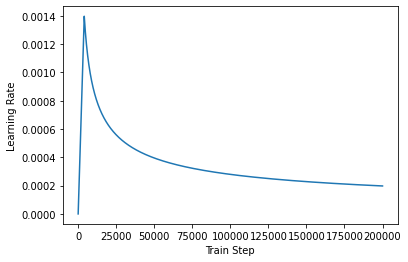

In [30]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [32]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', min_delta = 0.0005, mode = 'auto', patience=2, verbose=1)
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[es])

Epoch 1/50
90/90 [==============================] - 7s 24ms/step - loss: 6.0324 - accuracy: 0.0689
Epoch 2/50
90/90 [==============================] - 2s 23ms/step - loss: 5.4359 - accuracy: 0.1514
Epoch 3/50
90/90 [==============================] - 2s 23ms/step - loss: 4.8310 - accuracy: 0.2147
Epoch 4/50
90/90 [==============================] - 2s 24ms/step - loss: 4.3106 - accuracy: 0.2158
Epoch 5/50
90/90 [==============================] - 2s 23ms/step - loss: 3.9538 - accuracy: 0.2170
Epoch 6/50
90/90 [==============================] - 2s 24ms/step - loss: 3.7361 - accuracy: 0.2226
Epoch 7/50
90/90 [==============================] - 2s 24ms/step - loss: 3.5886 - accuracy: 0.2294
Epoch 8/50
90/90 [==============================] - 2s 23ms/step - loss: 3.4554 - accuracy: 0.2361
Epoch 9/50
90/90 [==============================] - 2s 24ms/step - loss: 3.3190 - accuracy: 0.2435
Epoch 10/50
90/90 [==============================] - 2s 23ms/step - loss: 3.1822 - accuracy: 0.2523
Epoch 11/

In [33]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

      # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [34]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print("gogo")

슝=3


### Step 5: 모델 평가하기

In [35]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

print("슝=3")

슝=3


In [36]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print("gogo")

gogo


### 실험정리: (전처리)vocab_size에 따라 loss&accuracy값이 달라지는가?
- 다른 조건은 동일하게, MAX_LENGTH=10, Epoch=50이지만 es설정해놓음
- 전처리를 해도 vocab_size = 8088로 동일 (어떻게 변화를 줘야될지 모르겠음)

|실험조건|[단어장의크기, 필터링후의 질문&답변샘플개수]|결과값|
|:---|:---:|---:|
|1. 데이터 전처리에서 drop_duplicate을 'Q'기준으로 drop + total_data_text(question+answer) 전체를 token화 했을때|[8088, 11622]|loss: 0.0594 - accuracy: 0.6546|
|2. 데이터 전처리에서 drop_duplicate을 'Q'기준으로 drop + total_data_text(question+answer)중에 encoder만 token화 했을때|[8088, 8954]|loss: 0.0568 - accuracy: 0.6549|
|3. 데이터 전처리에서 drop_duplicate을 'A'기준으로 drop + total_data_text(question+answer) 전체를 token화 했을때|[7781, 5754] |loss: 0.0510 - accuracy: 0.6887|
|4. 데이터 전처리에서 drop_duplicate을 'A'기준으로 drop + total_data_text(question+answer)중에 encoder만  token화 했을때|[7781 ,5754 ]|loss: 0.0496 - accuracy: 0.6905|

### 정리
- chatbot이 출력할 수 있는 답변이 한계가 있다보니, A를 기준으로 데이터 전처리했을때, 성능이 제일 높게 나온다 (<-- 당연한 논리임)

In [37]:
sentence_generation('뭐하고 있어?')
# 다른 질문 대입해보기

입력 : 뭐하고 있어?
출력 : 궁금하


'궁금하'

In [38]:
sentence_generation("이름이 뭐야?")
# 다른 답변 대입해보기

입력 : 이름이 뭐야?
출력 : 놀랐겠어요


'놀랐겠어요'

In [39]:
sentence_generation('배가 고팠어서 과식을 했어')
# 다른 질문 대입해보기

입력 : 배가 고팠어서 과식을 했어
출력 : 건 


'건 '

In [40]:
sentence_generation('1도 모르겠다')
# 다른 질문 대입해보기

입력 : 1도 모르겠다
출력 : 제 


'제 '

In [41]:
sentence_generation('일도 모르겠다')
# 다른 질문 대입해보기

입력 : 일도 모르겠다
출력 : 저는 


'저는 '

In [43]:
sentence_generation('배고파')
# 다른 질문 대입해보기

입력 : 배고파
출력 : 얼른 


'얼른 '

In [ ]:
sentence_generation('')
# 다른 질문 대입해보기

### AI, 윤리문제 재점화

In [47]:
sentence_generation('야식추천')

입력 : 야식추천
출력 : 사람 


'사람 '